In [1]:
import sys,os

sys.path.append(os.path.abspath('..'))

import torch
from colors import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
problems_by_category = {

    "encoding": [
        "size_negative",
        "shape_without_point",
        "size_without_point_text",
        "same_field_x_and_y",
        "same_field",
        "same_field_grt3",
        "rect_without_d_d",
        "number_categorical",
        "only_discrete",
        "only_y",
        "multi_non_pos",
        "non_pos_used_before_pos"
    ],
    "mark": [
        "line_area_with_discrete",
        "bar_tick_continuous_x_y",
        "bar_tick_area_line_without_continuous_x_y",
        "area_bar_with_log",
        "c_c_point",
        "c_c_line",
        "c_c_area",
        "d_d_point",
        "d_d_rect",
        "c_d_overlap_point",
        "c_d_overlap_bar",
        "c_d_overlap_line",
        "c_d_overlap_area",
        "c_d_overlap_tick",
        "c_d_no_overlap_point",
        "c_d_no_overlap_bar",
        "c_d_no_overlap_line",
        "c_d_no_overlap_area"
    ],
    "stack": [
        "no_stack_with_bar_area_discrete_color",
        "stack_without_discrete_color_or_detail",
        "stack_discrete"
    ],
    "scale": [
        "log_scale",
        "log_x",
        "log_y",
        "ordinal_scale",
        "ordinal_x",
        "ordinal_y",
        "categorical_scale",
        "categorical_color",
        "linear_color",
        "linear_size",
        "log_color",
        "log_size",
        "ordinal_color",
        "ordinal_size",
        "ordinal_shape"
    ],
    "data": [
        "high_cardinality_ordinal",
        "high_cardinality_categorical_grt10",
        "high_cardinality_shape",
        "high_cardinality_size",
        "horizontal_scrolling_x",
        "polar_coordinate"
    ]
}

In [3]:
# gpt_oss_vast = torch.load(f"./outputs/3_9_gpt-oss:20b_2000_VAST.out")
# gpt_oss = torch.load(f"./outputs/3_9_gpt-oss:20b_2000.out")

# gpt_oss_merged = gpt_oss.copy()

# gpt_oss_merged["gpt-oss:20b"]["outputs"] = gpt_oss_vast["gpt-oss:20b"]["outputs"] + gpt_oss["gpt-oss:20b"]["outputs"][:2]
# gpt_oss_merged["gpt-oss:20b"]["error_rate"] = gpt_oss_vast["gpt-oss:20b"]["error_rate"] + gpt_oss["gpt-oss:20b"]["error_rate"][:2]

# torch.save(gpt_oss_merged, "./outputs/final/3_9_gpt-oss:20b_2000.out")

In [4]:
models = ["llama3.1:8b","llama3.2:3b","gemma3:4b","gemma3:27b","gpt-oss:20b"] 
models = ["llama3.1:8b"]
outputs = {}

for model in models:
    outputs = outputs | torch.load(f"./outputs/final/3_9_{model}_2000.out")

outputs.keys()

dict_keys(['llama3.1:8b'])

In [5]:
df_problems = pd.read_csv("./draco-problems/problems.csv")
all_problems = set(list(df_problems["Name"]))

all_problems

{'area_bar_with_log',
 'bar_tick_area_line_without_continuous_x_y',
 'bar_tick_continuous_x_y',
 'c_c_area',
 'c_c_line',
 'c_c_point',
 'c_d_no_overlap_area',
 'c_d_no_overlap_bar',
 'c_d_no_overlap_line',
 'c_d_no_overlap_point',
 'c_d_overlap_area',
 'c_d_overlap_bar',
 'c_d_overlap_line',
 'c_d_overlap_point',
 'c_d_overlap_tick',
 'categorical_color',
 'categorical_scale',
 'd_d_point',
 'd_d_rect',
 'high_cardinality_categorical_grt10',
 'high_cardinality_ordinal',
 'high_cardinality_shape',
 'high_cardinality_size',
 'horizontal_scrolling_x',
 'line_area_with_discrete',
 'linear_color',
 'linear_size',
 'log_color',
 'log_scale',
 'log_size',
 'log_x',
 'log_y',
 'multi_non_pos',
 'no_stack_with_bar_area_discrete_color',
 'non_pos_used_before_pos',
 'number_categorical',
 'only_discrete',
 'only_y',
 'ordinal_color',
 'ordinal_scale',
 'ordinal_shape',
 'ordinal_size',
 'ordinal_x',
 'ordinal_y',
 'polar_coordinate',
 'rect_without_d_d',
 'same_field',
 'same_field_grt3',
 'same

In [6]:
def mean_dicts(dicts):
    """
    Calculate mean across a list of dictionaries.
    All dictionaries must have the same keys.
    """
    if not dicts:
        return {}

    keys = dicts[0].keys()
    return {k: np.mean([d[k] for d in dicts]) for k in keys}

In [7]:
def eval(outputs, all_problems, models):

    n = len(outputs[models[0]]["outputs"][0])
    reps = len(outputs[models[0]]["outputs"])
    results = {}

    for model in models:

        metrics = {problem: {"total_tp": [0] * reps, "total_fp": [0] * reps, "total_fn": [0] * reps, "precision": [], "recall": [], "f1": []} for problem in all_problems}

        for i in range(reps):
            for out in outputs[model]["outputs"][i]:

                if out["problems_pred"] != None:
                    
                    try:

                        gt = set(out["problems_gt"].split(","))
                        pred = set([problem for problem in out["problems_pred"] if problem in all_problems]) # filter out hallucinations

                        problems_tp = (gt & pred)
                        problems_fp = (pred - gt)
                        problems_fn = (gt - pred)

                        for problem in problems_tp: metrics[problem]["total_tp"][i] += 1
                        for problem in problems_fp: metrics[problem]["total_fp"][i] += 1
                        for problem in problems_fn: metrics[problem]["total_fn"][i] += 1

                    except Exception as e:
                        print(e)

            for problem in all_problems:

                total_tp = metrics[problem]["total_tp"][i]
                total_fp = metrics[problem]["total_fp"][i]
                total_fn = metrics[problem]["total_fn"][i]

                metrics[problem]["precision"].append(total_tp / (total_tp + total_fp) if total_tp + total_fp > 0 else 0)
                metrics[problem]["recall"].append(total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0)

                precision = metrics[problem]["precision"][i]
                recall = metrics[problem]["recall"][i]

                metrics[problem]["f1"].append(2 * precision * recall / (precision + recall) if precision + recall > 0 else 0)

        f1_mean_dict = {k: np.mean(v['f1']) for k, v in metrics.items()}
        f1_std_dict = {k: np.std(v['f1']) for k, v in metrics.items()}
        
        f1_mean = np.mean(list(f1_mean_dict.values()))
        f1_std = np.std(list(f1_mean_dict.values()))

        acc_adherence = 100 - np.mean(outputs[model]["error_rate"])

        results[model] = {  "n": n,
                            "f1_mean": f1_mean,
                            "f1_std": f1_std,
                            "reps": reps,
                            "acc_adherence": acc_adherence,
                            "f1_problems": f1_mean_dict,
                            "f1_std_problems": f1_std_dict}
    
    return results

results = eval(outputs, all_problems, models)
results

{'llama3.1:8b': {'n': 2000,
  'f1_mean': 0.12156805273651543,
  'f1_std': 0.09207984520116314,
  'reps': 5,
  'acc_adherence': 64.86,
  'f1_problems': {'horizontal_scrolling_x': 0.060999586923977514,
   'number_categorical': 0.17962446845928695,
   'ordinal_color': 0.04265057161005509,
   'only_discrete': 0.13816608326134694,
   'ordinal_scale': 0.3120355676193046,
   'same_field': 0.20219188489956066,
   'high_cardinality_shape': 0.08647101339761186,
   'ordinal_y': 0.08578673049891256,
   'c_c_line': 0.14317707732721116,
   'c_d_no_overlap_line': 0.01818181818181818,
   'ordinal_shape': 0.009910228223216003,
   'size_without_point_text': 0.33418780569499057,
   'rect_without_d_d': 0.11814704666532357,
   'high_cardinality_categorical_grt10': 0.1703704724767349,
   'bar_tick_continuous_x_y': 0.13079193333961617,
   'c_d_overlap_tick': 0.01773226773226773,
   'd_d_point': 0.007216578626574563,
   'no_stack_with_bar_area_discrete_color': 0.10030047026060115,
   'bar_tick_area_line_witho

In [8]:
def get_latex(results):

    models = list(results.keys())
    n = results[models[0]]["n"]

    # header of aggregated results by category

    header_rows = []
    for category, problems in problems_by_category.items():

        row = "& Avg."

        f1s = []
        stds = []

        for model in models:

            f1s_model = []
            stds_model = []

            for problem in problems:

                f1s_model.append(results[model]["f1_problems"][problem])
                stds_model.append(results[model]["f1_std_problems"][problem])

            f1s.append(np.mean(f1s_model))
            stds.append(np.mean(stds_model))

        max_f1 = max(np.round(f1s, 2))

        for f1, std in zip(f1s, stds):

            if np.round(f1, 2) != np.round(max_f1, 2): 
                row += f" & {f1:.2f} & {std:.2f}" 
            else:
                row += " & " + r"\textbf{" + f"{f1:.2f}" + "}" + f" & {std:.2f}" 

        row += " \\\\"
        header_rows.append(row)

    # results for all problems

    for category, problems in problems_by_category.items():

        print("\n")
        print(r"\midrule")
        print(r"\multirow{" + str(len(problems)) + r"}{*}{\rotatebox[origin=c]{90}{\makebox[1cm]{"+ category +r"}}}","\n")

        for problem in problems:

            row = "& " + problem.replace("_","\_")

            f1s = []
            stds = []

            for model in models:

                f1 = results[model]["f1_problems"][problem]
                std = results[model]["f1_std_problems"][problem]

                f1s.append(f1)
                stds.append(std)

            max_f1 = max(np.round(f1s, 2))

            for f1, std in zip(f1s, stds):

                if np.round(f1, 2) != np.round(max_f1, 2): 
                    row += f" & {f1:.2f} & {std:.2f}" 
                else:
                    row += " & " + r"\textbf{" + f"{f1:.2f}" + "}" + f" & {std:.2f}" 

            row += " \\\\"
            print(row)
        
        print()
        print(r"\midrule")
        print(header_rows.pop(0))                        

get_latex(results)



\midrule
\multirow{12}{*}{\rotatebox[origin=c]{90}{\makebox[1cm]{encoding}}} 

& size\_negative & \textbf{0.05} & 0.00 \\
& shape\_without\_point & \textbf{0.20} & 0.01 \\
& size\_without\_point\_text & \textbf{0.33} & 0.01 \\
& same\_field\_x\_and\_y & \textbf{0.16} & 0.03 \\
& same\_field & \textbf{0.20} & 0.00 \\
& same\_field\_grt3 & \textbf{0.07} & 0.02 \\
& rect\_without\_d\_d & \textbf{0.12} & 0.02 \\
& number\_categorical & \textbf{0.18} & 0.03 \\
& only\_discrete & \textbf{0.14} & 0.03 \\
& only\_y & \textbf{0.13} & 0.02 \\
& multi\_non\_pos & \textbf{0.14} & 0.02 \\
& non\_pos\_used\_before\_pos & \textbf{0.12} & 0.02 \\

\midrule
& Avg. & \textbf{0.15} & 0.02 \\


\midrule
\multirow{18}{*}{\rotatebox[origin=c]{90}{\makebox[1cm]{mark}}} 

& line\_area\_with\_discrete & \textbf{0.08} & 0.01 \\
& bar\_tick\_continuous\_x\_y & \textbf{0.13} & 0.02 \\
& bar\_tick\_area\_line\_without\_continuous\_x\_y & \textbf{0.14} & 0.00 \\
& area\_bar\_with\_log & \textbf{0.13} & 0.01 \\
& 

/tmp/ipykernel_313404/470053810.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Pastel1", n_models)


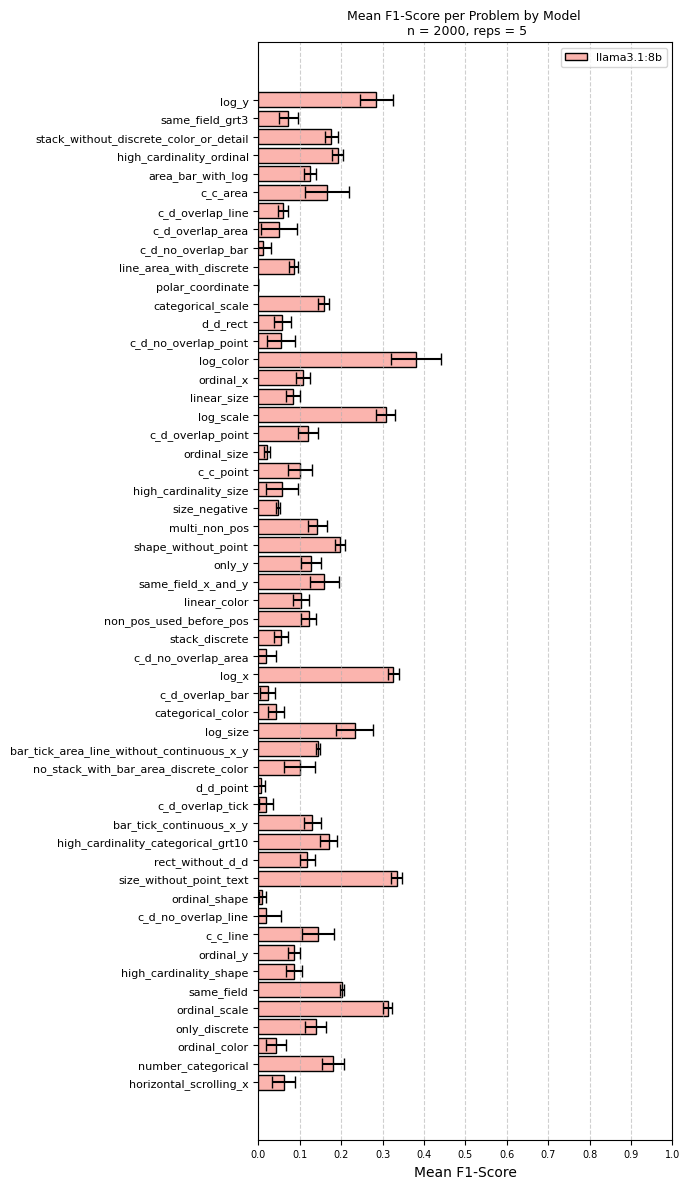

In [19]:
def plot_f1_by_problems(results, figheight=15):

    models = list(results.keys())
    
    # Use problems from the first model
    problems = list(results[models[0]]["f1_problems"].keys())
    n_models = len(models)
    n_problems = len(problems)

    # Extract means and stds directly
    means = np.array([[results[m]["f1_problems"][p] for p in problems] for m in models])
    stds = np.array([[results[m]["f1_std_problems"][p] for p in problems] for m in models])

    # Grouped bar positions
    y = np.arange(n_problems)
    bar_height = 0.8 / n_models
    offsets = np.linspace(-0.4 + bar_height/2, 0.4 - bar_height/2, n_models)

    plt.figure(figsize=(7, figheight))
    cmap = plt.cm.get_cmap("Pastel1", n_models)
    colors = [cmap(i) for i in range(n_models)]

    for i, model in enumerate(models):
        plt.barh(
            y + offsets[i],
            means[i],
            xerr=stds[i],
            height=bar_height,
            label=model,
            capsize=4,
            edgecolor="black",
            color=colors[i]
        )

    reps = results[models[0]]["reps"]
    n = results[models[0]]["n"]

    plt.title(f"Mean F1-Score per Problem by Model \n n = {n}, reps = {reps}", fontsize=9)
    plt.xlabel("Mean F1-Score")
    plt.yticks(y, problems, fontsize=8)
    plt.xticks(np.linspace(0, 1, 11), fontsize=7)
    plt.xlim(0, 1)
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

plot_f1_by_problems(results, figheight=12)

In [10]:
for model in models:
    print(model, results[model]["acc_adherence"] / 100) 

llama3.1:8b 0.6486


**ASP vs. Human**

In [11]:
models = ["llama3.2:3b","gemma3:4b"] 
outputs_asp = {}
outputs_human = {}

for model in models:
    outputs_asp = outputs_asp | torch.load(f"./outputs/final/asp_vs_human/6_9_{model}_2000_asp.out")
    outputs_human = outputs_human | torch.load(f"./outputs/final/asp_vs_human/6_9_{model}_2000_human.out")

outputs_human.keys()

dict_keys(['llama3.2:3b', 'gemma3:4b'])

In [12]:
results_asp = eval(outputs_asp, all_problems, models)
results_human = eval(outputs_human, all_problems, models)

In [13]:
results_asp

{'llama3.2:3b': {'n': 2000,
  'f1_mean': 0.07308803993781961,
  'f1_std': 0.06441668385352184,
  'reps': 3,
  'acc_adherence': 96.41666666666667,
  'f1_problems': {'horizontal_scrolling_x': 0.06931786453970755,
   'number_categorical': 0.0859420083685025,
   'ordinal_color': 0.01879596012363415,
   'only_discrete': 0.08798317582344388,
   'ordinal_scale': 0.1184898530579442,
   'same_field': 0.08582806855992824,
   'high_cardinality_shape': 0.10429111929561807,
   'ordinal_y': 0.04073641613391191,
   'c_c_line': 0.06015280382276178,
   'c_d_no_overlap_line': 0.010256410256410256,
   'ordinal_shape': 0.01873224043715847,
   'size_without_point_text': 0.3844436640981968,
   'rect_without_d_d': 0.1168284922208329,
   'high_cardinality_categorical_grt10': 0.12526106804305448,
   'bar_tick_continuous_x_y': 0.10016502104706278,
   'c_d_overlap_tick': 0.014221955768718361,
   'd_d_point': 0.027681759342238155,
   'no_stack_with_bar_area_discrete_color': 0.09675384198747061,
   'bar_tick_area_

/tmp/ipykernel_313404/2778101898.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Pastel1", n_models)


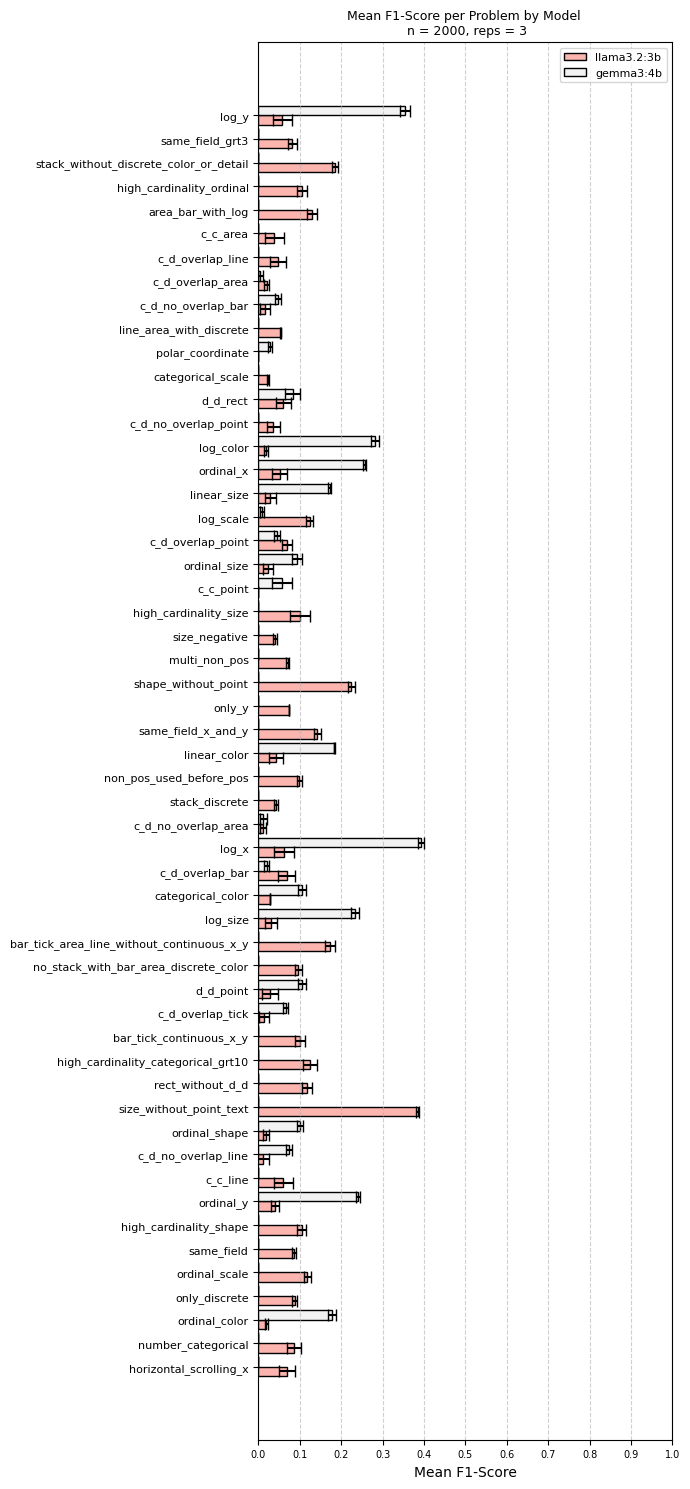

In [14]:
plot_f1_by_problems(results_asp)

/tmp/ipykernel_313404/2778101898.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Pastel1", n_models)


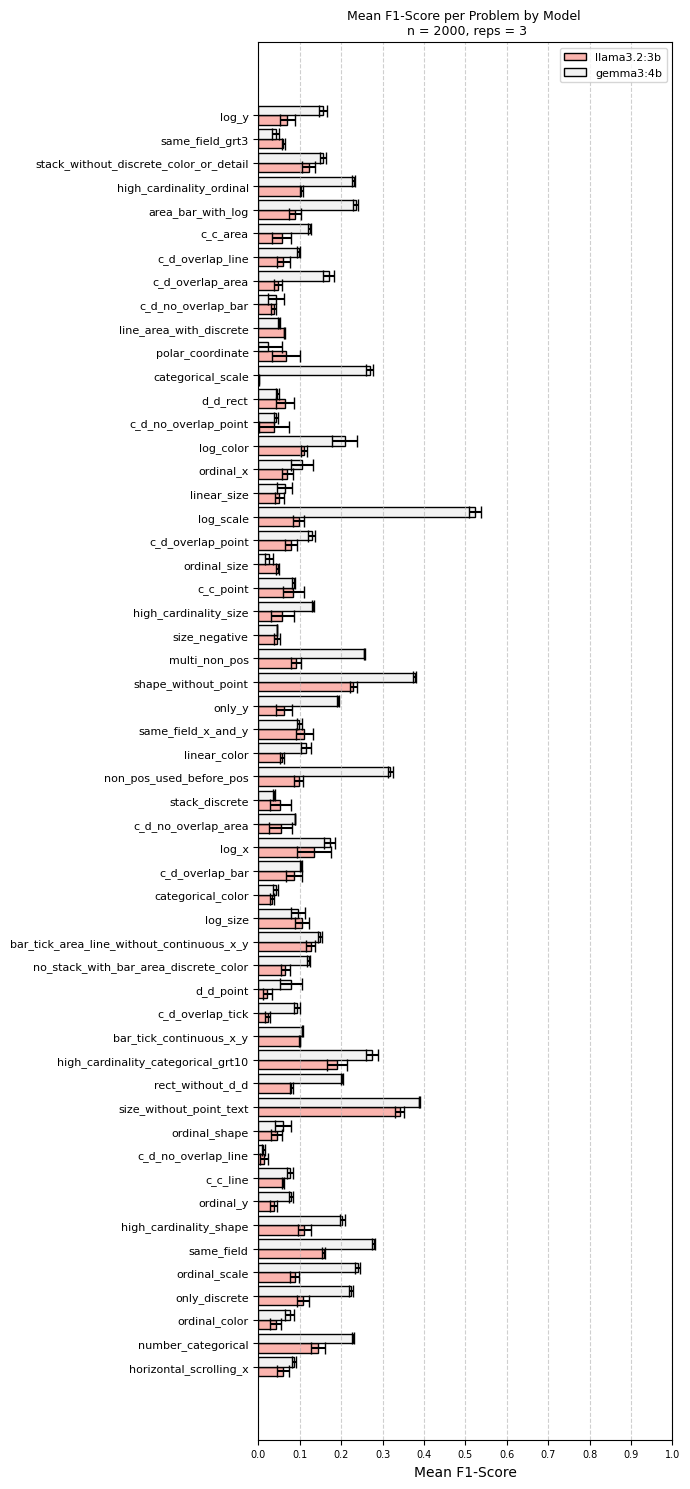

In [15]:
plot_f1_by_problems(results_human)

In [16]:
f1s_asp = [results_asp["llama3.2:3b"]["f1_mean"], results_asp["gemma3:4b"]["f1_mean"]]
f1s_human = [results_human["llama3.2:3b"]["f1_mean"], results_human["gemma3:4b"]["f1_mean"]]

stds_asp = [results_asp["llama3.2:3b"]["f1_std"], results_asp["gemma3:4b"]["f1_std"]]
stds_human = [results_human["llama3.2:3b"]["f1_std"], results_human["gemma3:4b"]["f1_std"]]

In [17]:
f1s_asp, f1s_human

([0.07308803993781961, 0.058329590334599515],
 [0.08224732016910341, 0.1458243111465891])